# Toxicity and Misoginy

In this jupyter notebook, we analyze how different subbredits and forums exhibited different levels of toxicity and misoginistic language, as measured by perspective API and a lexicon by [Farell et al 2019](https://github.com/miriamfs/WebSci2019/blob/master/Lexicon.txt).



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np
import swifter
import json
import pandas as pd
import re

# Seaborn
import seaborn as sns
sns.set_style("ticks")

# Latex Configuration
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import os
fontpath = os.path.expanduser('~/.local/share/fonts/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 16,
    'axes.labelsize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': prop.get_name(),
    'text.usetex': True
}
mpl.rcParams.update(params)

# Local Modules
import os
import sys
sys.path.insert(0, os.path.abspath('/data/savvas/incels/manosphere_analysis/helpers/'))
from plot import set_size, plot_toxicity
from lexicon import hostility, flipping, sexual_violence, belitting, patriarchy, stoicism, count_words
categories_pretty = { 'mgtow': 'MGTOW', 'trp': 'TRP', 'pua': 'PUA', 'incels': 'Incels', 'mra': 'MRA'}

# Loads and preprocesses data

In [3]:
# load data from JSON files

JSON_DATA_BASE_DIR = '/data/savvas/incels/data/json/'
json_data_files = ['reddit.ndjson', 'incels.ndjson', 'rooshv.ndjson', 
                   'the_attraction.ndjson', 'pua_forum.ndjson',
                   'mgtow.ndjson', 'avfm.ndjson']
platform_names = ['Reddit', 'Incels.is', 'Rooshv', 'The Attraction', 
                  'MPUAForum', 'MGTOW Forum', 'AVFM']


In [4]:

dfs = []

for i in range(len(json_data_files)):
    d = []
    with open(JSON_DATA_BASE_DIR + json_data_files[i], 'r') as f:
        for line in f:
            data = json.loads(line)
            d.append(data)
    dfs.append(pd.DataFrame(d))

In [5]:
json_data_files = ['/control/4chan/4chan_random_sample.ndjson', 
                   '/control/reddit/random/reddit_random_comments.ndjson',
                   '/control/gab/gab_corpus2.ndjson']
platform_names = ['4chan', 'reddit', 'gab']

dfs_control = []

for i in range(len(json_data_files)):
    print(platform_names[i])
    d = []
    idy = 0
    with open(JSON_DATA_BASE_DIR + json_data_files[i], 'r') as f:
        for line in f:
            if idy % 1000000 == 0:
                print(idy)
            data = json.loads(line)
            if i == 0:
                if data["body"] == "N/A":
                    continue
                data = {"text_post": data["body"], "date_post": data["ts"], "id": data["id"]}

            if i == 1:
                data = {"text_post": data["body"], "date_post": int(data["created_utc"]), "id": data["id"]}
            if i == 2:
                data = {"text_post": data["content"], "date_post": data["created_at"], "id": data["id"]}
            d.append(data)
            idy+=1

    dfs_control.append(pd.DataFrame(d))
dfs_control[0]

4chan
0
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
19000000
19000000
19000000
19000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
26000000
27000000
28000000
29000000
30000000
31000000
reddit
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
gab
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000


,text_post,date_post,id
0,norf lads destroy kebab shop with truck:\nhttp...,1561039538,216891032
1,>>216891248\n\nthat's literally how football b...,1561041288,216893488
2,">>216894818\nOkay, based.\n\nWhat about the pa...",1561042379,216895080
3,>>216893547\n>The UK has an ancient tradition ...,1561042768,216895655
4,>>216895655\noh really?,1561043253,216896403
...,...,...,...
31656462,>>226505999\nNo phase 2 u fucking kike,1568439186,226506499
31656463,>>226499370\nWhoa he likes to Drink Behind the...,1568432718,226499521
31656464,>>226499370\nPost tits TayTay,1568438027,226505313
31656465,>>226499370\n>Moslem\nSeems like that hat is a...,1568438209,226505502


In [6]:
def map_or_none(id_post, mapping):
    try:
        a = mapping[id_post]
        return a
    except KeyError:
        return None
    
def load_mapping_into_df(df, mapping_file, mapping_json_keys, key_name_df):
    mapping = {}
    with open(mapping_file, 'r') as f:
        for line in f:
            data = json.loads(line)
            val = data
            for key in mapping_json_keys:
                val = val[key]
            mapping[data['id_post']] = val
            
    df[key_name_df] = df['id_post'].apply(map_or_none, args=(mapping,))
    return df

BASE_DIR_PERPSECTIVE = '/data/savvas/incels/data/json/perspective2/'
platform_names_raw = ['redditall', 'incels', 'rooshv', 'the_attraction', 'pua_forum',
                  'red_pill_talk', 'mgtow', 'avfm']
perspective_files = [BASE_DIR_PERPSECTIVE + 'perspective_severity_' + x +'_results.txt' for x in platform_names_raw]

i=0
for df in dfs:
    print(platform_names_raw[i])
    df = load_mapping_into_df(df, perspective_files[i], ['hate_output', 'SEVERE_TOXICITY'], 'perspective_toxicity')
    i+=1

redditall
incels
rooshv
the_attraction
pua_forum
red_pill_talk
mgtow


In [7]:
# perspective_severe4chan_random_sample_results.txt

BASE_DIR_PERSPECTIVE_CONTROL = "/data/savvas/incels/data/json/control/"

def load_mapping_into_df(df, mapping_file, mapping_json_keys, key_name_df):
    mapping = {}
    with open(mapping_file, 'r') as f:
        idy = 0
        for line in f:
            if idy % 1000000 == 0:
                print(idy)
            data = json.loads(line)
            val = data
            for key in mapping_json_keys:
                val = val[key]
            mapping[data['id_post']] = val
            idy += 1
        
            
    df[key_name_df] = df['id'].apply(map_or_none, args=(mapping,))
    return df

platform_names_raw = ['4chan', 'reddit', 'gab']
perspective_files = [
    BASE_DIR_PERSPECTIVE_CONTROL + '/4chan/perspective_severe4chan_random_sample_results.txt',
    BASE_DIR_PERSPECTIVE_CONTROL + "/reddit/random/perspective_severe_reddit_random_comments_results.txt",
    BASE_DIR_PERSPECTIVE_CONTROL + "/gab/perspective_severe_gab_corpus2_results.txt"
]

i=0
for df in dfs_control:
    print(platform_names_raw[i])
    df = load_mapping_into_df(df, perspective_files[i], ['hate_output', 'SEVERE_TOXICITY'], 'perspective_toxicity')
    i+=1

4chan
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
28000000
29000000
30000000
31000000
32000000
reddit
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000
27000000
gab
0
1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
11000000
12000000
13000000
14000000
15000000
16000000
17000000
18000000
19000000
20000000
21000000
22000000
23000000
24000000
25000000
26000000


In [8]:
for i in range(len(dfs)):
    df = dfs[i]
    if i==0:
        df['datetime'] = pd.to_datetime(df['date_post'], unit='s')
    else:
        df['datetime'] = pd.to_datetime(df['date_post'])
    i+=1
    
for i in range(len(dfs_control)):
    df = dfs_control[i]
    if i != 2:
        df['datetime'] = pd.to_datetime(df['date_post'], unit='s')
    else:
        df['datetime'] = pd.to_datetime(df['date_post'])
    i+=1

In [9]:
# Removes health and criticism subreddits
to_remove = ["TheBluePill", "exredpill", "depression", "socialanxiety", "SuicideWatch", "IncelTears"]
for subreddit in to_remove:
    dfs[0] = dfs[0].loc[dfs[0].subreddit != subreddit]

In [10]:
# Removes pre-2019
for i in range(len(dfs)):
    dfs[i] = dfs[i].loc[dfs[i]['datetime'].dt.year < 2019]

In [11]:
def to_lowercase(s):
    return s.lower()

# do the same on the reddit dataset based on the categories
categoriesdf = pd.read_csv('/data/savvas/incels/subreddit_categories.txt')
categoriesdf = categoriesdf.loc[(categoriesdf.category != "criticism") & (categoriesdf.category != "health")]
redditdf = dfs[0]
redditdf['subreddit_lower'] = redditdf['subreddit'].map(to_lowercase)
categories_map = {}
for idx, row in categoriesdf.iterrows():
    categories_map[row['subreddits']] = row['category']
redditdf['subreddit_category'] = redditdf['subreddit_lower'].map(categories_map)  
categories = sorted((list(set(redditdf['subreddit_category'].tolist()))))
categories_pretty = { 'mgtow': 'MGTOW', 'trp': 'TRP', 'pua': 'PUA', 'incels': 'Incels', 'mra': 'MRA'}

# Counts lexicon occurrence on  dataframe

In [12]:
dfs[0]["lexicon_p"] = dfs[0].text_post.swifter.allow_dask_on_strings().apply(
    lambda x: count_words([hostility, flipping, sexual_violence, belitting, patriarchy, stoicism], x))

In [13]:
for df in dfs[1:]:
    print(len(df))
    df["lexicon_p"] = df.text_post.swifter.allow_dask_on_strings().apply(
    lambda x: count_words([hostility, flipping, sexual_violence, belitting, patriarchy, stoicism], x))

1770159



1433186



892199



888962



776073



210640


In [ ]:
for df in dfs_control:
    print(len(df))
    df["lexicon_p"] = df.text_post.swifter.allow_dask_on_strings().apply(
    lambda x: count_words([hostility, flipping, sexual_violence, belitting, patriarchy, stoicism], x))

31656467



28000478


In [ ]:
for df in dfs + dfs_control:
    df["hostility"] = df["lexicon_p"].swifter.apply(lambda x: x[0])
    df["flipping"] = df["lexicon_p"].swifter.apply(lambda x: x[1])
    df["sexual_violence"] = df["lexicon_p"].swifter.apply(lambda x: x[2])
    df["belitting"] = df["lexicon_p"].swifter.apply(lambda x: x[3])
    df["patriarchy"] = df["lexicon_p"].swifter.apply(lambda x: x[4])
    df["stoicism"] = df["lexicon_p"].swifter.apply(lambda x: x[5])
    df["lexicon"] = df["hostility"] + df["flipping"] +\
                    df["sexual_violence"] + df["belitting"] +\
                    df["patriarchy"] + df["stoicism"]    

# Saves Stuff

In [ ]:
# Fixes reddit dataset column type
for col in ["author", "id_post", "subreddit", "text_post", "thread", "subreddit_lower", "subreddit_category"]:
    dfs[0][col] = dfs[0][col].astype(str)
dfs[0].date_post = dfs[0].date_post.astype(int)
dfs[0].datetime = pd.to_datetime(dfs[0].datetime)

print(0)
dfs[0].reset_index().to_feather("/data/savvas/incels/manosphere_analysis/helpers/dfs/df_{}".format(str(0)))

for idx, df in enumerate(dfs):
    if idx == 0:
        continue
    print(idx)
    df.reset_index().to_feather("/data/savvas/incels/manosphere_analysis/helpers/dfs/df_{}".format(str(idx)))

for idx, df in enumerate(dfs_control):
    print(idx)
    df.reset_index().to_feather("/data/savvas/incels/manosphere_analysis/helpers/dfs/df_{}_c".format(str(idx)))

#  (or) Loads Stuff

In [ ]:
dfs = []
dfs_control = []

for idx in range(7):
    print(idx)
    dfs.append(
        pd.read_feather("/data/savvas/incels/manosphere_analysis/helpers/dfs/df_{}".format(str(idx)))
    )

for idx in range(3):
    print(idx)
    dfs_control.append(
        pd.read_feather("/data/savvas/incels/manosphere_analysis/helpers/dfs/df_{}_c".format(str(idx)))
    )
                      

In [ ]:
redditdf = dfs[0]
categories = sorted((list(set(redditdf['subreddit_category'].tolist()))))

# Toxicity Plot

In [ ]:
def get_toxicity(df, key, func):
        tmp = df.dropna(subset=[key]).groupby(pd.Grouper(key='datetime', freq='M'))[key].apply(
            lambda x: bs.bootstrap(x.values, func, num_iterations=1000)
        )

        point_estimate = tmp.apply(lambda x: x.value)
        low = tmp.apply(lambda x: x.lower_bound)
        high = tmp.apply(lambda x: x.upper_bound)

        return pd.DataFrame({"low": low, "high": high, "pe": point_estimate})

vals_t_reddit = []
vals_l_reddit = []
vals_t_forums = []
vals_l_forums = []
vals_t_control = []
vals_l_control = []

for cat in categories:
    print(cat)
    df = redditdf.loc[redditdf.subreddit_category == cat]
    vals_l_reddit.append(get_toxicity(df, "lexicon", bs_stats.mean))
    vals_t_reddit.append(get_toxicity(df, "perspective_toxicity", bs_stats.mean))
                         
for df in dfs[1:]:
    print(len(df))
    vals_l_forums.append(get_toxicity(df, "lexicon", bs_stats.mean))
    vals_t_forums.append(get_toxicity(df, "perspective_toxicity", bs_stats.mean))
            
for df in dfs_control[1:2]:
    print(len(df))
    vals_l_control.append(get_toxicity(df, "lexicon", bs_stats.mean))
    vals_t_control.append(get_toxicity(df, "perspective_toxicity", bs_stats.mean))

incels
mgtow


/home/manoel/miniconda3/envs/manosphere/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:447: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
/home/manoel/miniconda3/envs/manosphere/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


mra
pua
trp
1770159
1433186
892199
888962
776073
210640
28000478


In [ ]:
# fixes max reddit date
flag = vals_t_control[0].index < pd.to_datetime("2019-01-01")
vals_t_control[0] = vals_t_control[0][flag]
flag = vals_l_control[0].index < pd.to_datetime("2019-01-01")
vals_l_control[0] = vals_l_control[0][flag]

In [ ]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


chan_toxicity = mean_confidence_interval(dfs_control[0].dropna()["perspective_toxicity"].values)
gab_toxicity = mean_confidence_interval(dfs_control[2].dropna()["perspective_toxicity"].values)
chan_lexicon = mean_confidence_interval(dfs_control[0].dropna()["lexicon"].values)
gab_lexicon = mean_confidence_interval(dfs_control[2].dropna()["lexicon"].values)

In [39]:
colors_f = ["#000000", "#171515", "#0b431c", "#559b5b", "#1e6b4d", "#864f0d", "#762a83"]
ls_f = ["-", "-", "-", ":", "-.", "-", "-", "-"]
colors_c = ["#171515", "#864f0d", "#762a83", "#559b5b", "#e08214"]
ls_c = ["-", "-", ":", "--", "-."]

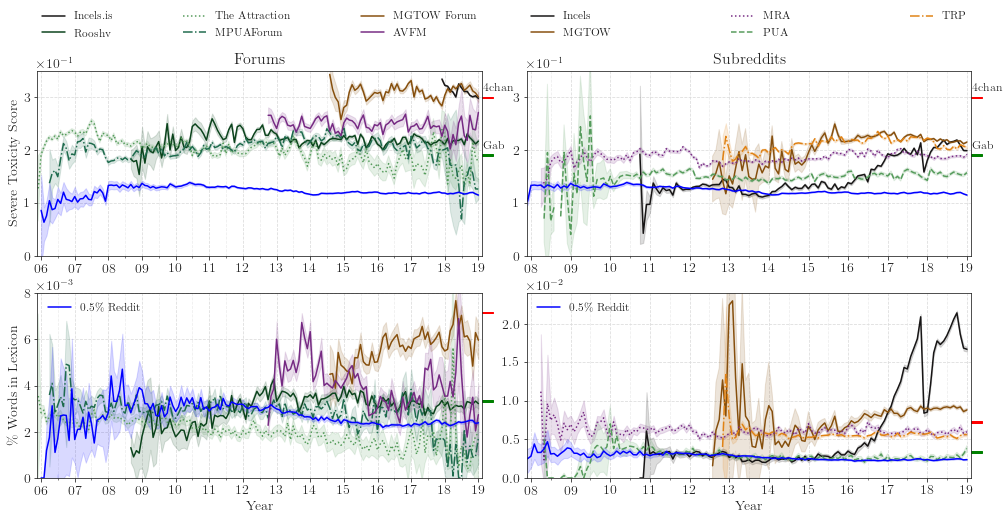

In [40]:
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches


def plot_hline(ax, val, text, color):
    y1, y2  =ax.get_ylim()
    trans = transforms.blended_transform_factory(
        ax.transAxes, ax.transData)
    
    rect = mpatches.Rectangle((1, val[1]), width=.025, height=(y2-y1)/100,
                         transform=trans, color=color, clip_on=False)
    ax.add_patch(rect)
    
    if text is not False:
        ax.text(1.001, val[2] + 0.0125, text, 
                         transform=trans, ha='left', size=12)

    
fig, axs_all = plt.subplots(2, 2, figsize=(14, 7.25), gridspec_kw={"wspace": 0.1}, sharey=False)

axs = axs_all[0, :]

plot_toxicity(vals_t_forums, colors_f[1:], ls_f[1:], forums=True, legend=True, 
              leg=['Incels.is', 'Rooshv', 'The Attraction', 
                  'MPUAForum', 'MGTOW Forum', 'AVFM'], ncols=3, ax=axs[0])

plot_toxicity(vals_t_reddit, colors_c, ls_c, forums=False, legend=True, 
              leg=[categories_pretty[x] for x in categories], ncols=3,
             ax=axs[1])

plot_toxicity([vals_t_control[0]], ["blue"], ls_c[1:], forums=True, legend=False, 
              leg=["reddit"], ncols=3, ax=axs[0])

plot_toxicity([vals_t_control[0]], ["blue"], ls_c[1:], forums=False, legend=False, 
              leg=["reddit"], ncols=3, ax=axs[1])


axs[0].set_ylabel("Severe Toxicity Score")
axs[0].set_title("Forums")
axs[1].set_title("Subreddits")
axs[1].set_ylim(0, 0.35)
axs[0].set_ylim(0, 0.35)
plot_hline(axs[0], gab_toxicity, "Gab", color="green")
plot_hline(axs[1], gab_toxicity, "Gab", color="green")
plot_hline(axs[0], chan_toxicity, "4chan", color="red")
plot_hline(axs[1], chan_toxicity, "4chan", color="red")


axs = axs_all[1, :]

plot_toxicity(vals_l_forums, colors_f[1:], ls_f[1:], forums=True, legend=False, 
              leg=['Incels.is', 'Rooshv', 'The Attraction', 
                  'MPUAForum', 'MGTOW Forum', 'AVFM'], ncols=3, ax=axs[0])

plot_toxicity(vals_l_reddit, colors_c, ls_c, forums=False, legend=False, 
              leg=[categories_pretty[x] for x in categories], ncols=3,
             ax=axs[1])

plot_toxicity([vals_l_control[0]], ["blue"], ls_c[1:], forums=True, legend=False, inner_legend=True,
              leg=["0.5\% Reddit"], ncols=3, ax=axs[0])

plot_toxicity([vals_l_control[0]], ["blue"], ls_c[1:], forums=False, legend=False, inner_legend=True,
          leg=["0.5\% Reddit"], ncols=3, ax=axs[1])

axs[0].set_ylabel("\% Words in Lexicon")
axs[1].set_ylim(0, 0.024)
axs[0].set_ylim(0, 0.008)
plot_hline(axs[0], gab_lexicon, text=False, color="green")
plot_hline(axs[1], gab_lexicon, text=False, color="green")
plot_hline(axs[0], chan_lexicon, text=False, color="red")
plot_hline(axs[1], chan_lexicon,text=False, color="red")

axs[0].set_xlabel("Year")
axs[1].set_xlabel("Year")
set_size(fig, (14, 7.25))

fig.savefig('/data/savvas/incels/manosphere_analysis/images/all_toxicity.pdf', bbox_inches='tight')

# Gets bootstrapped toxicity values

In [45]:
def get_toxicity(df, key, func):
        tmp = df.dropna(subset=[key]).groupby(pd.Grouper(key='datetime', freq='M'))[key].apply(
            lambda x: bs.bootstrap(x.values, func, num_iterations=10)
        )

        point_estimate = tmp.apply(lambda x: x.value)
        low = tmp.apply(lambda x: x.lower_bound)
        high = tmp.apply(lambda x: x.upper_bound)

        return pd.DataFrame({"low": low, "high": high, "pe": point_estimate})

In [41]:
four_chan_lex = get_toxicity(dfs_control[0], "lexicon", bs_stats.mean)
four_chan_lex

,low,high,pe
datetime,,,
2016-06-30,0.006736,0.008161,0.007258
2016-07-31,0.006622,0.006771,0.006710
2016-08-31,0.006793,0.006884,0.006807
2016-09-30,0.006508,0.006637,0.006556
2016-10-31,0.007105,0.007180,0.007126
2016-11-30,0.006573,0.006675,0.006634
2016-12-31,0.006694,0.006766,0.006712
2017-01-31,0.006877,0.006949,0.006908
2017-02-28,0.006811,0.007009,0.006880


In [42]:
four_chan_per = get_toxicity(dfs_control[0], "perspective_toxicity", bs_stats.mean)
four_chan_per

,low,high,pe
datetime,,,
2016-06-30,0.310547,0.317528,0.313908
2016-07-31,0.315790,0.316682,0.316176
2016-08-31,0.315914,0.317046,0.316492
2016-09-30,0.311208,0.311986,0.311624
2016-10-31,0.304395,0.305360,0.304820
2016-11-30,0.293924,0.294750,0.294166
2016-12-31,0.285224,0.286323,0.285860
2017-01-31,0.285562,0.286232,0.285851
2017-02-28,0.285995,0.286581,0.286382


In [43]:
gab_lex = get_toxicity(dfs_control[2], "lexicon", bs_stats.mean)
gab_lex

,low,high,pe
datetime,,,
2016-08-31 00:00:00+00:00,0.002338,0.002547,0.002406
2016-09-30 00:00:00+00:00,0.002561,0.002674,0.002640
2016-10-31 00:00:00+00:00,0.003072,0.003193,0.003102
2016-11-30 00:00:00+00:00,0.002799,0.002865,0.002830
2016-12-31 00:00:00+00:00,0.002846,0.002970,0.002911
2017-01-31 00:00:00+00:00,0.003196,0.003237,0.003227
2017-02-28 00:00:00+00:00,0.003362,0.003458,0.003422
2017-03-31 00:00:00+00:00,0.003418,0.003552,0.003481
2017-04-30 00:00:00+00:00,0.003297,0.003416,0.003343


In [44]:
gab_per = get_toxicity(dfs_control[2], "perspective_toxicity", bs_stats.mean)
gab_per

,low,high,pe
datetime,,,
2016-08-31 00:00:00+00:00,0.198682,0.201168,0.199814
2016-09-30 00:00:00+00:00,0.203434,0.204473,0.204054
2016-10-31 00:00:00+00:00,0.195959,0.196758,0.196328
2016-11-30 00:00:00+00:00,0.184335,0.184804,0.184597
2016-12-31 00:00:00+00:00,0.185467,0.186076,0.185680
2017-01-31 00:00:00+00:00,0.188668,0.189481,0.189035
2017-02-28 00:00:00+00:00,0.177425,0.178156,0.177827
2017-03-31 00:00:00+00:00,0.173538,0.174319,0.173867
2017-04-30 00:00:00+00:00,0.170863,0.171811,0.171150


---